In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

import warnings
warnings.filterwarnings('ignore')

In [2]:

from google.colab import files
uploaded = files.upload()


fname = list(uploaded.keys())[0]
df = pd.read_csv(fname, parse_dates=['Date'])
df.sort_values('Date', inplace=True)
df.reset_index(drop=True, inplace=True)

df.head(), df.shape


Saving HistoricalQuotes.csv to HistoricalQuotes (1).csv


(        Date  Close/Last     Volume       Open       High        Low
 0 2010-03-01    $29.8557  137312041   $29.3928   $29.9286     $29.35
 1 2010-03-02    $29.8357  141486282     $29.99   $30.1186   $29.6771
 2 2010-03-03    $29.9043   92846488   $29.8486   $29.9814   $29.7057
 3 2010-03-04    $30.1014   89591907   $29.8971   $30.1314   $29.8043
 4 2010-03-05    $31.2786  224647427   $30.7057   $31.3857   $30.6614,
 (2518, 6))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2518 entries, 0 to 2517
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         2518 non-null   datetime64[ns]
 1    Close/Last  2518 non-null   object        
 2    Volume      2518 non-null   int64         
 3    Open        2518 non-null   object        
 4    High        2518 non-null   object        
 5    Low         2518 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 118.2+ KB


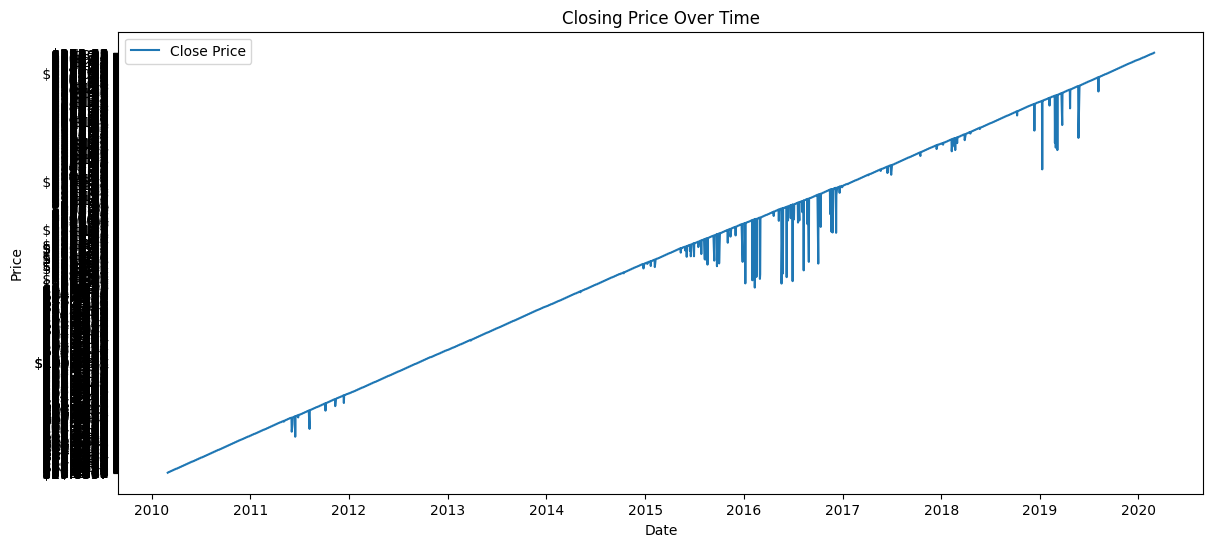

In [5]:
df.info()
df.isna().sum()


df.fillna(method='ffill', inplace=True)


data = df[['Date', ' Close/Last']].copy()
plt.figure(figsize=(14,6))
plt.plot(data['Date'], data[' Close/Last'], label='Close Price')
plt.title('Closing Price Over Time')
plt.xlabel('Date'); plt.ylabel('Price')
plt.legend()
plt.show()

In [6]:

data[' Close/Last'] = data[' Close/Last'].astype(str).str.replace(r'[$, ]', '', regex=True).astype(float)

values = data[' Close/Last'].values.reshape(-1,1)
scaler = MinMaxScaler()
scaled = scaler.fit_transform(values)


train_size = int(len(scaled) * 0.8)
train, test = scaled[:train_size], scaled[train_size:]

In [7]:

def create_lr_features(dataset):
    X, y = dataset[:-1], dataset[1:]
    return X, y

X_train_lr, y_train_lr = create_lr_features(train)
X_test_lr, y_test_lr = create_lr_features(test)

lr = LinearRegression()
lr.fit(X_train_lr, y_train_lr)
pred_lr = lr.predict(X_test_lr)

rmse_lr = np.sqrt(mean_squared_error(y_test_lr, pred_lr))
print(f"Linear Regression RMSE: {rmse_lr:.5f}")


Linear Regression RMSE: 0.01245


In [8]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_lr, y_train_lr.ravel())
pred_rf = rf.predict(X_test_lr)

rmse_rf = np.sqrt(mean_squared_error(y_test_lr, pred_rf))
print(f"Random Forest RMSE: {rmse_rf:.5f}")


Random Forest RMSE: 0.17384


In [9]:
def create_sequences(dataset, timesteps=60):
    X, y = [], []
    for i in range(timesteps, len(dataset)):
        X.append(dataset[i-timesteps:i, 0])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

timesteps = 60
X_train_ls, y_train_ls = create_sequences(train, timesteps)
X_test_ls, y_test_ls = create_sequences(test, timesteps)

X_train_ls = X_train_ls.reshape((X_train_ls.shape[0], X_train_ls.shape[1], 1))
X_test_ls = X_test_ls.reshape((X_test_ls.shape[0], X_test_ls.shape[1], 1))


In [10]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(timesteps,1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

history = model.fit(X_train_ls, y_train_ls, batch_size=32, epochs=20,
                    validation_split=0.1, verbose=1)
pred_ls = model.predict(X_test_ls)

rmse_ls = np.sqrt(mean_squared_error(y_test_ls, pred_ls))
print(f"LSTM RMSE: {rmse_ls:.5f}")


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0065 - val_loss: 2.9133e-04
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 4.4359e-04 - val_loss: 3.5011e-04
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.0679e-04 - val_loss: 3.6452e-04
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.9112e-04 - val_loss: 3.2218e-04
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.7427e-04 - val_loss: 3.1345e-04
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.4476e-04 - val_loss: 2.8909e-04
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.2608e-04 - val_loss: 2.4643e-04
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.9752e-04 - val_loss: 2.4287e-04
Epoch 9/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.7059e-04 - val_loss: 2.3704e-04
Epoch 10/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.0598e-04 - val_loss: 2.6296e-04
Epoch 11/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.7777e-04 - va

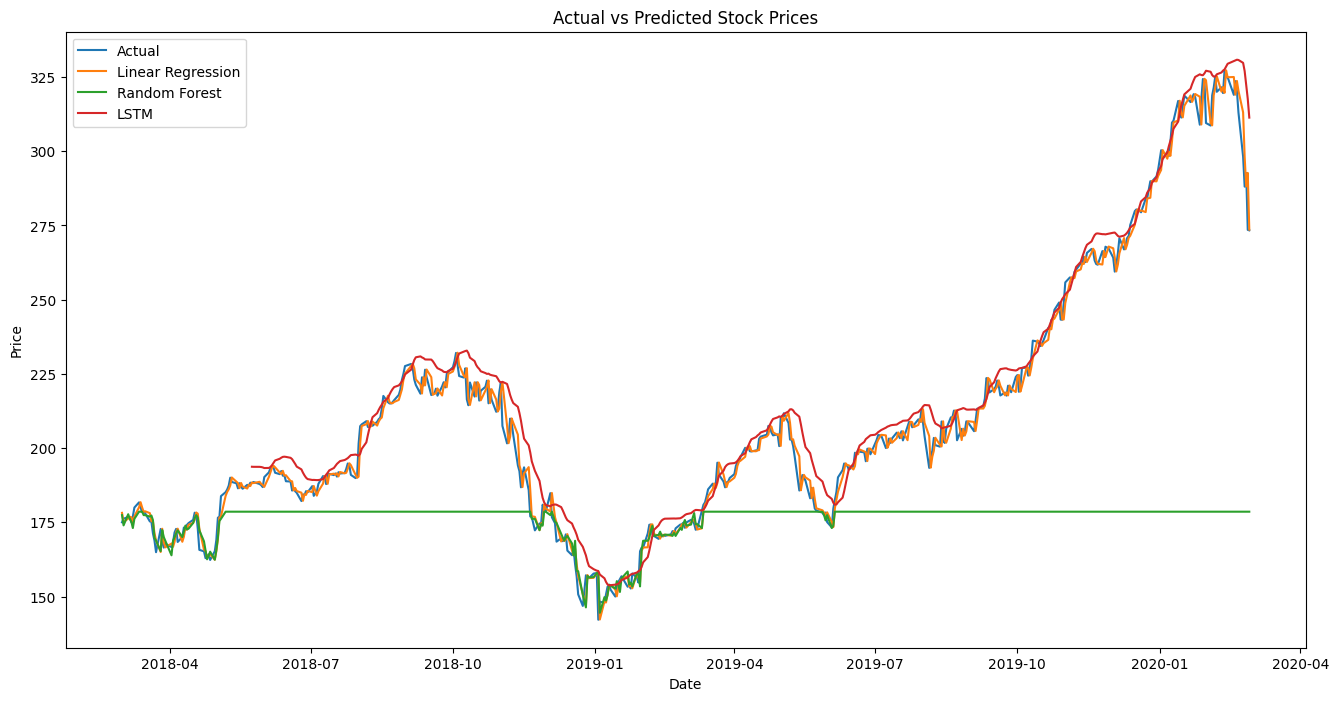

In [ ]:
# Inverse scale
y_test_lr_real = scaler.inverse_transform(y_test_lr)
pred_lr_real = scaler.inverse_transform(pred_lr)
pred_rf_real = scaler.inverse_transform(pred_rf.reshape(-1,1))

y_test_ls_real = scaler.inverse_transform(y_test_ls.reshape(-1,1))
pred_ls_real = scaler.inverse_transform(pred_ls)

plt.figure(figsize=(16,8))
plt.plot(data['Date'][-len(y_test_lr_real):], y_test_lr_real, label='Actual')
plt.plot(data['Date'][-len(pred_lr_real):], pred_lr_real, label='Linear Regression')
plt.plot(data['Date'][-len(pred_rf_real):], pred_rf_real, label='Random Forest')
plt.plot(data['Date'][-len(pred_ls_real):], pred_ls_real, label='LSTM')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Date'); plt.ylabel('Price')
plt.legend(); plt.show()


In [ ]:
print("✅ Model RMSE Comparison:")
print(f"Linear Regression: {rmse_lr:.4f}")
print(f"Random Forest:     {rmse_rf:.4f}")
print(f"LSTM:              {rmse_ls:.4f}")


✅ Model RMSE Comparison:
Linear Regression: 0.0124
Random Forest:     0.1738
LSTM:              0.0272
